In [1]:
BATCH_SIZE=64

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import torchvision.models
import os

In [3]:
IMG_SIZE=32
transform_normal = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 数据增强
transform_aug = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomCrop(IMG_SIZE,IMG_SIZE//8),
    transforms.RandomHorizontalFlip(),
   
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing()

])

training_data = torchvision.datasets.CIFAR100(root = '../../data',train =True,download=True,transform=transform_aug)
test_data  = torchvision.datasets.CIFAR100(root = '../../data',train=False,download=True,transform=transform_normal)


train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True,pin_memory=True)



test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False,pin_memory=True)

print(training_data[0][0].shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])


In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device=torch.device(device)

In [5]:
model= torch.load('resnet18_cifar100_base.pt')
_=model.to(device)


In [6]:
def check_acc(model,epoch=0,epochs=1):
    _tqdm=tqdm(test_dataloader,total=len(test_dataloader))
    model.eval()
    with torch.no_grad():
        total_num=0
        right_num=0
        model=model.eval()
        for img,label in _tqdm:
            img=img.to(device)
            label=label.to(device)
            total_num=total_num+img.shape[0]
            predicted_outputs=model(img)
            right_num         +=   torch.sum(torch.argmax(predicted_outputs,dim=-1)==label)
            acc=right_num/total_num
            _tqdm.set_description_str(f'test {epoch}/{epochs} test acc:{acc*100:.1f}%')
    return acc
    

In [7]:
check_acc(model)

test 0/1 test acc:77.9%: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]


tensor(0.7794, device='cuda:0')

In [8]:
#把一个模型的所有梯度都去掉
def freeze_model(model):
    for p in model.parameters():
         p.requires_grad = False
    return model

#输出一个层阶段的feature    
def get_feature(model, x):
    # See note [TorchScript super()]
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    
    #x = model.avgpool(x)
    #x = torch.flatten(x, 1)
    #x = model.fc(x)

    return x
#使用feature计算输出
# 注意: 
# 
# 直接调用model.forward()等价于feature_forward(get_feature()) 
#
def feature_forward(model,x) :
    #x = model.layer4(x)

    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    x = model.fc(x)
    return x 

In [9]:


def get_old_new_feature(model,dataloader,calc_new = True):
    _tqdm=tqdm(dataloader,total=len(dataloader))
    loss_fn = nn.CrossEntropyLoss()
        #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    feature_list = list()
    feature_new_list  = list()
    for img,label in _tqdm:
        img=img.to(device)
        label=label.to(device)
        feature = get_feature(model,img)
        feature_list.append(feature.cpu())

        
        if calc_new:
            feature_new=feature.clone()
            feature_new.requires_grad_(True)
            optimizer = optim.SGD([feature_new], lr=1e0)
            for _ in range(20):
                optimizer.zero_grad()
                predicted_outputs=feature_forward(model,feature_new)
                right_num         =   torch.sum(torch.argmax(predicted_outputs,dim=-1)==label)
                #print(train_loss.item(),right_num)
                if  right_num >= img.shape[0]*0.95 :
                    break
                
                train_loss = loss_fn(predicted_outputs, label)
                train_loss.backward()
                optimizer.step()

            feature_new_list.append(feature_new.requires_grad_(False).cpu())
    features = torch.concat(feature_list)
    if calc_new:
        features_new = torch.concat(feature_new_list)        
        return features,features_new
    else:
        return features

In [10]:
model.eval()
freeze_model(model)
features_train,features_new_train=get_old_new_feature(model,train_dataloader)
features_val,features_new_val=get_old_new_feature(model,test_dataloader)

100%|██████████| 79/79 [00:05<00:00, 15.60it/s]


In [11]:
N_FEATURE=features_new_train.shape[1]

In [12]:
features_new_train.shape

torch.Size([49984, 512, 4, 4])

In [13]:

s1=features_train.mean([2,3])
features_train_m=s1

#plt.figure(figsize=(40,40))
#for i in range(256):
#    ax=plt.subplot(16,16,i+1)
#    ax.axis('off')
#    plt.hist(s1[:,i].numpy())

In [14]:

s2=features_val.mean([2,3])
features_val_m=s2
#plt.figure(figsize=(40,40))
#for i in range(256):
#    ax=plt.subplot(16,16,i+1)
#    ax.axis('off')
#    plt.hist(s2[:,i].numpy())

In [15]:
features_new_train_m=features_new_train.mean([2,3])
features_new_val_m=features_new_val.mean([2,3])

In [16]:
#for i in range(256):
#    plt.figure()
#    t1,i1=features_train_m[:,i].sort()
#    plt.hist(features_new_train_m[:,i][i1]-t1)
#    plt.grid()
#    break

In [17]:
def save_features_picture():
    os.makedirs('features',exist_ok=True)
    for i in tqdm(range(N_FEATURE)):
        plt.figure()
        t1,i1=features_train_m[:,i].sort()
        tdiff=t1-features_new_train_m[i1,i]
        mean = t1.mean()
        std  = t1.std()
        t1=(t1-mean)/std
        tdiff /= std
        plt.scatter(t1,tdiff,s=1)
        plt.title(str(i))
        plt.savefig(f'features/{i}.jpg')
        plt.close()

#save_features_picture()

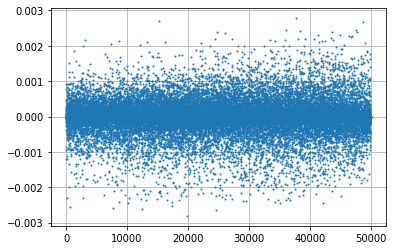

In [18]:
i=16
t1,i1=features_train_m[:,i].sort()
tdiff=t1-features_new_train_m[i1,i]
t1=(t1-t1.mean())/t1.std()
#plt.scatter(t1,tdiff,s=0.1)
plt.plot(tdiff,'o',markersize=1)
plt.grid()

In [19]:
t1=t1[:499*100]
tdiff=tdiff[:499*100]

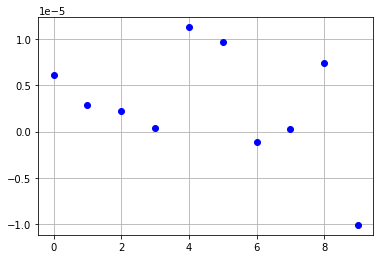

In [20]:
plt.plot(tdiff.view(10,-1).mean(-1),'bo')
plt.grid()

In [21]:
tdiff.mean()

tensor(2.9050e-06)

In [22]:
m=torch.zeros((N_FEATURE))
for i in tqdm(range(N_FEATURE)):
    t1,i1=features_train_m[:,i].sort()
    tdiff=features_new_train_m[i1,i]-t1
    m[i]=tdiff.mean()

    

100%|██████████| 512/512 [00:03<00:00, 164.63it/s]


In [23]:
def check_acc_for_mean(model,dataloader,m):
    _tqdm=tqdm(dataloader,total=len(dataloader))
    model.eval()
    if m is not None:
        m=m.to(device)
    with torch.no_grad():
        total_num=0
        right_num=0
        
        for img,label in _tqdm:
            img=img.to(device)
            label=label.to(device)
            total_num=total_num+img.shape[0]
            
            f=get_feature(model,img)
            
            if m is not None:
                f=f.permute((0,2,3,1))
                f+=m
                f=f.permute((0,3,1,2))
            
            predicted_outputs=feature_forward(model,f)
            right_num         +=   torch.sum(torch.argmax(predicted_outputs,dim=-1)==label)
            acc=right_num/total_num
            _tqdm.set_description_str(f'test acc:{acc*100:.1f}%')
            
    return acc

In [24]:

check_acc_for_mean(model,test_dataloader,m)

test acc:77.9%: 100%|██████████| 79/79 [00:03<00:00, 21.32it/s]


tensor(0.7794, device='cuda:0')

In [25]:
check_acc_for_mean(model,test_dataloader,None)

test acc:77.9%: 100%|██████████| 79/79 [00:03<00:00, 22.48it/s]


tensor(0.7794, device='cuda:0')

(array([  1.,  15.,  40., 107., 148., 108.,  65.,  21.,   6.,   1.]),
 array([-8.5007568e-06, -6.5910681e-06, -4.6813793e-06, -2.7716903e-06,
        -8.6200146e-07,  1.0476874e-06,  2.9573762e-06,  4.8670649e-06,
         6.7767542e-06,  8.6864429e-06,  1.0596132e-05], dtype=float32),
 <BarContainer object of 10 artists>)

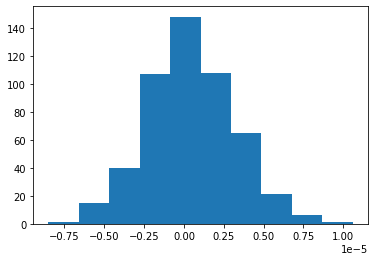

In [26]:
plt.hist(m.numpy())